<a href="https://colab.research.google.com/github/modelflows/notebooks/blob/main/deep-learning/modelFlows_ar_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autoregressive (AR) Variational Autoencoder (VAE)
Official implementation of the AR VAE model to forecast flow dynamics of a laminar flow past a circular cylinder.

[R. Abadía-Heredia, A. Corrochano, M. Lopez-Martin and S. Le Clainche. "Generalization capabilities and robustness of hybrid machine learning models grounded in flow physics compared to purely deep learning models." 	arXiv:2404.17884 (2024)](https://doi.org/10.48550/arXiv.2404.17884)

**Description**

This model, which is based on a variational autoencoder model, approximates the probability distribution behind the forecasting process. Predicted snapshots are sample from the approximated distribution.

Given the architecture of the model, it can only be trained on a single velocity component at a time. To apply this model to new datasets, the architecture has to be modified.

A GPU is required for a fast training of the VAE model and a minimum system RAM of 51 GB. However, the model can be loaded with weights from a previous successful training, allowing to compute predictions without training. The weights for this model can be found [here](https://drive.google.com/drive/folders/1kgr0hx5jE4cRNe6oLY9Un5xXMan4Nwqn?usp=sharing) under the name `weights_vae_laminar_streamwise.h5` and `weights_vae_laminar_normal.h5`.

The key hyperameters are the following:

* ```vel_comp``` (str)      -> String defining which velocity component use for training the VAE model. The prediction will be done in the same component. The two options available are: "streamwise" or "wall_normal".
* ```inp_seq``` (int)       -> Number (> 1) of samples that enter as input to the POD-DL model.
* ```batch_size``` (int)    -> Number (> 4) of samples that defines the batch size that is used for training.
* ```num_preds``` (int)     -> Number (>= 1) of predictions to compute after training.
* ```train_size``` (float)  -> Percentage ((0,1)) of dataset to use for training the POD-DL model.

In [ ]:
try:
  import mat73
except:
  !pip install -q mat73
  import mat73

In [ ]:
!pip install -q tensorflow==2.15.0
!pip install -q tensorflow-probability==0.23

In [ ]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns

from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

#from keras.callbacks import Callback

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv2D, ConvLSTM2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU, ReLU, Input
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, UpSampling2D, TimeDistributed, LayerNormalization
from tensorflow.keras.layers import Dropout, BatchNormalization

In [ ]:
font = {'size'   : 18}

matplotlib.rc('font', **font)

In [ ]:
seed = 98374598
tf.random.set_seed(seed)
np.random.seed(seed)

# Hyperparameters

In [ ]:
vel_comp    = "streamwise" # streamwise or wall_normal
inp_seq     = 10
batch_size  = 8
num_preds   = 200
train_size  = 0.6

# Load Data

In [ ]:
data_dict = mat73.loadmat('DATA/dataset_laminar.mat')
Ten_orig = data_dict['Tensor'][:,:,:,:,100:]

# Data Split

In [ ]:
if (vel_comp == "streamwise"):
    # Streamwise velocity
    train_set = np.copy(Ten_orig[0:1,...,:int(train_size * Ten_orig.shape[-1])])
    dev_set = np.copy(Ten_orig[0:1,...,int(train_size * Ten_orig.shape[-1]):int((train_size + 0.05) * Ten_orig.shape[-1])])
    test_set = np.copy(Ten_orig[0:1,...,int((train_size + 0.05) * Ten_orig.shape[-1]):])

elif (vel_comp == "wall_normal"):
    # Wall-normal velocity
    train_set = np.copy(Ten_orig[1:2,...,:int(train_size * Ten_orig.shape[-1])])
    dev_set = np.copy(Ten_orig[1:2,...,int(train_size * Ten_orig.shape[-1]):int((train_size + 0.05) * Ten_orig.shape[-1])])
    test_set = np.copy(Ten_orig[1:2,...,int((train_size + 0.05) * Ten_orig.shape[-1]):])

else:
    raise TypeError("vel_comp has to be streamwise or wall_normal")

# Scailing between 0 and 1
ten_min = np.amin(train_set)
ten_range = np.ptp(train_set)

# ten_min = np.mean(train_set, axis = -1)[..., None]
# ten_range = np.std(train_set)

train_set = (train_set - ten_min) / ten_range
dev_set = (dev_set - ten_min) / ten_range
test_set = (test_set - ten_min) / ten_range

# Channels last, time first
train_set = np.transpose(train_set, [4,1,2,3,0])
dev_set = np.transpose(dev_set, [4,1,2,3,0])
test_set = np.transpose(test_set, [4,1,2,3,0])

print(f"Train set shape: {train_set.shape}")
print(f"Dev set shape: {dev_set.shape}")
print(f"Test set shape: {test_set.shape}")

Train set shape: (299, 100, 40, 64, 1)
Dev set shape: (25, 100, 40, 64, 1)
Test set shape: (175, 100, 40, 64, 1)


# Data Windowing

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, samplingRate, batch_size,
            train_df=train_set, val_df=dev_set, test_df=test_set):

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.sampling_rate = samplingRate

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}'])

def split_window(self, features):
    inputs = features[:, self.input_slice, ...]
    labels = features[:, self.labels_slice, ...]

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None, None, None])
    labels.set_shape([None, self.label_width, None, None, None])

    return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data, state):
    data = np.array(data, dtype=np.float32)
    if (state == "training"):
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            sampling_rate = self.sampling_rate,
            shuffle = True,
            batch_size = self.batch_size)

    else:
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            sampling_rate = self.sampling_rate,
            shuffle = False,
            batch_size = self.batch_size)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self, state = "training"):
    return self.make_dataset(self.train_df, state)

@property
def val(self, state = "not_training"):
    return self.make_dataset(self.val_df, state)

@property
def test(self, state = "not_training"):
    return self.make_dataset(self.test_df, state)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [ ]:
def window_generator(inputWidth):

  labelWidth=1
  shift=1

  w1 = WindowGenerator(input_width = inputWidth, label_width = labelWidth,
                      shift = shift, samplingRate = 1, batch_size = batch_size,
                      train_df = train_set[:,:,:,0,:], val_df = dev_set[:,:,:,0,:],
                       test_df = test_set[:,:,:,0,:])

  w_train = w1.train
  w_val = w1.val

  for i in range(1,Ten_orig.shape[-2]):
    w2 = WindowGenerator(input_width = inputWidth, label_width = labelWidth,
                      shift = shift, samplingRate = 1, batch_size = batch_size,
                      train_df = train_set[:,:,:,i,:], val_df = dev_set[:,:,:,i,:],
                      test_df = test_set[:,:,:,i,:])

    w_train = w_train.concatenate(w2.train)
    w_val = w_val.concatenate(w2.val)

  del w1, w2

  return w_train, w_val

In [ ]:
w_train, w_val = window_generator(inp_seq)

Number of training batches: 2368

Inputs shape (batch size, time, features): (8, 10, 100, 40, 1)
Labels shape (batch size, time, features): (8, 1, 100, 40, 1)


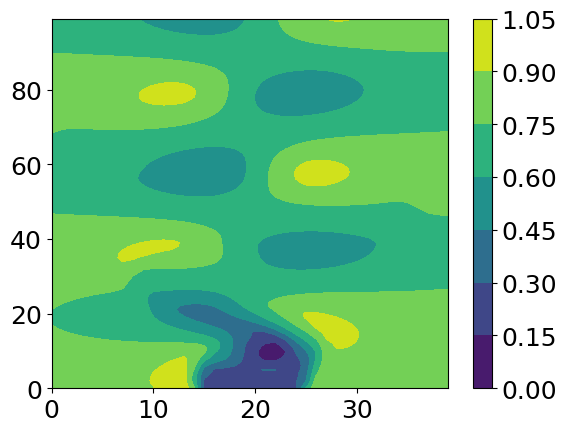

In [ ]:
print(f"Number of training batches: {len(w_train)}")

for example_inputs, example_labels in w_train.take(1):
  in_shape = (example_inputs.shape[1], example_inputs.shape[2], example_inputs.shape[3], example_inputs.shape[4])
  print(f'\nInputs shape (batch size, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch size, time, features): {example_labels.shape}')

plt.close('all')
plt.contourf(example_inputs[0,0,:,:,0])
plt.colorbar()

# VAE

## KL divergence

In [ ]:
def get_kl_regularizer(latent_dim):
  """
  The prior of latent variables is considered a standard Normal distribution.
  Therefore this function creates the KLDivergenceRegularizer that will be used
  in the ELBO.
  """

  return tfpl.KLDivergenceRegularizer(
      tfd.MultivariateNormalDiag(loc = tf.zeros(latent_dim),
                                 scale_diag = tf.ones(latent_dim)),
      use_exact_kl = False,
      test_points_fn = lambda q: q.sample(30),
      weight = 1.0,
      test_points_reduce_axis = None)

## Inference

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def get_encoder(latent_dim, in_shape, kl_regularizer):

  model = Sequential([
      Input(shape = in_shape),

      Conv2D(filters=8, kernel_size=7, strides=1, padding='valid',
             data_format='channels_last', kernel_initializer='he_uniform'),
      ReLU(),
      LayerNormalization(),

      Conv2D(filters=16, kernel_size=3, strides=2, padding='valid',
             data_format='channels_last', kernel_initializer='he_uniform'),
      ReLU(),
      LayerNormalization(),

      Conv2D(filters=32, kernel_size=3, strides=(2,1), padding='valid',
             data_format='channels_last', kernel_initializer='he_uniform'),
      ReLU(),
      LayerNormalization(),

      ConvLSTM2D(64, (3, 3), strides = (2,1), padding="same",
                 return_sequences=False, data_format='channels_last'),
      LayerNormalization(),

      Flatten(),
      Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),

      tfpl.MultivariateNormalTriL(latent_dim,
        convert_to_tensor_fn = tfp.distributions.Distribution.sample,
        activity_regularizer = kl_regularizer)

  ], name='encoder')

  return model

## Generation

In [ ]:
def get_decoder(latent_dim, num_kernels):

  inputs = Input(shape=(latent_dim,))

  x = Dense(units=9856, activation='relu',
            kernel_initializer='he_uniform')(inputs)
  x = Reshape((11,14,64))(x)

  x = Conv2DTranspose(filters=64, kernel_size=3, strides=(2,1), padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)

  x_probs = Flatten()(x)
  x_probs = Dense(num_kernels, activation='softmax')(x_probs)

  x = Conv2DTranspose(filters=32, kernel_size=3, strides=(2,1), padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)

  x = Conv2DTranspose(filters=16, kernel_size=(4,3), strides=2, padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)

  x = Conv2DTranspose(filters=8, kernel_size=(5,4), strides=1, padding='valid',
                      data_format='channels_last', activation='relu',
                      kernel_initializer='he_uniform')(x)
  x = ReLU()(x)
  x = tf.keras.layers.LayerNormalization()(x)



  x = Conv2D(filters=2*num_kernels, kernel_size=1, strides=1, activation=None,
             padding='valid', data_format='channels_last')(x)
  x = tf.transpose(x, perm = [0,3,1,2])

  x = [x_probs, x]

  outputs = tfpl.DistributionLambda(
    lambda t: tfd.MixtureSameFamily(
        mixture_distribution = tfd.Categorical(probs=t[0]),
        components_distribution = tfd.Independent(
            tfd.MultivariateNormalDiag(loc=t[1][:,:num_kernels,...],
                                       scale_diag=tf.nn.softplus(t[1][:,num_kernels:,...])
                                       ),
                                       reinterpreted_batch_ndims=1
            )
        )
    )(x)

  return Model(inputs=inputs, outputs=outputs, name='decoder')

## Variational Autoencoder

In [ ]:
tf.keras.backend.clear_session()

latent_dim = 25

num_kernels_dec = 15

kl_regularizer = get_kl_regularizer(latent_dim)

encoder = get_encoder(latent_dim, in_shape, kl_regularizer)

decoder = get_decoder(latent_dim, num_kernels_dec)

vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 94, 34, 8)     400       
                                                                 
 re_lu (ReLU)                (None, 10, 94, 34, 8)     0         
                                                                 
 layer_normalization (Layer  (None, 10, 94, 34, 8)     16        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 46, 16, 16)    1168      
                                                                 
 re_lu_1 (ReLU)              (None, 10, 46, 16, 16)    0         
                                                                 
 layer_normalization_1 (Lay  (None, 10, 46, 16, 16)    32        
 erNormalization)                                          

In [ ]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 9856)                 256256    ['input_2[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 11, 14, 64)           0         ['dense_1[0][0]']             
                                                                                                  
 conv2d_transpose (Conv2DTr  (None, 23, 16, 64)           36928     ['reshape[0][0]']             
 anspose)                                                                                   

In [ ]:
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 100, 40, 1)   0         
                             ]                                   
                                                                 
 conv2d (Conv2D)             (None, 10, 94, 34, 8)     400       
                                                                 
 re_lu (ReLU)                (None, 10, 94, 34, 8)     0         
                                                                 
 layer_normalization (Layer  (None, 10, 94, 34, 8)     16        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 46, 16, 16)    1168      
                                                                 
 re_lu_1 (ReLU)              (None, 10, 46, 16, 16)    0     

## Loss Function

In [ ]:
def reconstruction_loss(target_modes, var_posterior):
    """
    This function defines the loss function. Note that only the log likelihood
    is implemented, because the KL term is already included in the encoder.
    """

    return(-tf.reduce_mean(var_posterior.log_prob(tf.squeeze(target_modes))))

# Training (IF the model was not previously trained)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
vae.compile(optimizer = optimizer, loss = reconstruction_loss)

In [ ]:
t0 = time.time()

history = vae.fit(w_train, validation_data = w_val, epochs = 30) # 20

t1 = time.time()

print(f"Training time {(t1 - t0)/60} minutes.")

Epoch 1/30
  53/2368 [..............................] - ETA: 9:08 - loss: 3642.4805

KeyboardInterrupt: 

## Load weights from a pretrained model

In [ ]:
if (vel_comp == "streamwise"):
    vae.load_weights("Models_weights/weights_vae_laminar_streamwise.h5")
else:
    vae.load_weights("Models_weights/weights_vae_laminar_normal.h5")

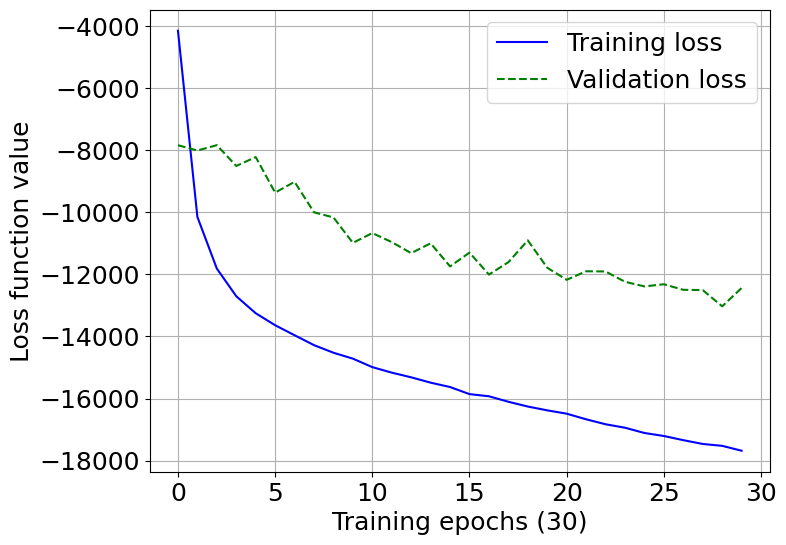

In [ ]:
# Plot loss evolution
"""
fig = plt.figure(figsize = (8, 6))
plt.plot(history.history['loss'], 'b', label = 'Training loss')
plt.plot(history.history['val_loss'], 'g--', label = 'Validation loss')
plt.xlabel(f'Training epochs ({len(history.history["loss"])})')
plt.ylabel('Loss function value')
plt.grid()
plt.legend()
"""

# Prediction

In [ ]:
def evaluate_model_test_iter(ten_orig_1, time_pred = 10, start_pnt = 10):

  ten_orig = np.copy(ten_orig_1)

  predictions = np.empty((ten_orig.shape[1], ten_orig.shape[2],
                          ten_orig.shape[3], time_pred))

  snap = np.copy(ten_orig[..., start_pnt-10:start_pnt])
  snap = (snap - ten_min) / ten_range
  snap = np.transpose(snap, [3,4,1,2,0])

  for i in range(time_pred):

    pred = vae.predict(snap, verbose = 0)

    pred_1 = np.transpose(np.copy(pred), [1,2,0])
    pred_1 = pred_1 * ten_range + ten_min

    predictions[...,i] = pred_1

    pred = pred[:,None,:,:,None]
    snap = np.concatenate([snap[:,1:,:,:,:], pred], axis = 1)

  del ten_orig, snap, pred, pred_1

  return predictions

In [ ]:
t0 = time.time()

start_pnt = train_set.shape[0]

if (vel_comp == "streamwise"):
    predictions = evaluate_model_test_iter(Ten_orig[0:1,...], num_preds, start_pnt)
else:
    predictions = evaluate_model_test_iter(Ten_orig[1:2,...], num_preds, start_pnt)

t1 = time.time()
print("Seconds elapsed: %f" % (t1 - t0))

Seconds elapsed: 119.370279


Text(0.5, 1.0, 'Forecast')

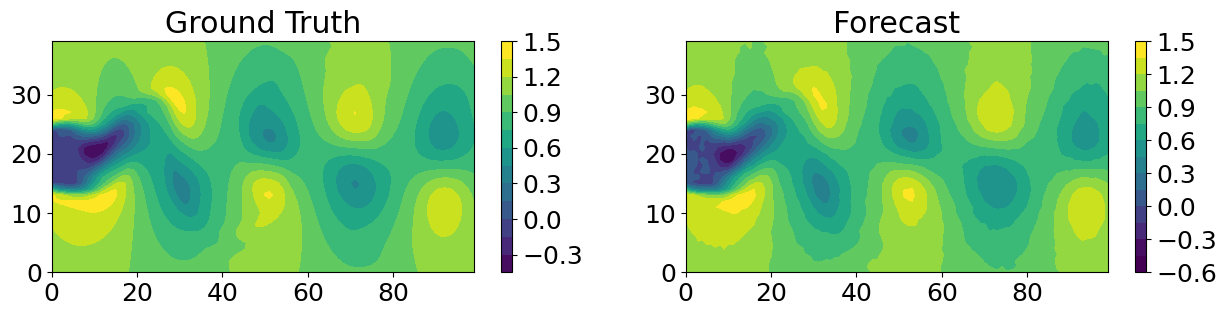

In [ ]:
select_snap = 40
span_ch = 32

snap_pred = predictions[:, :, span_ch, select_snap]

if (vel_comp == "streamwise"):
    snap_target = Ten_orig[0, :, :, span_ch, start_pnt + select_snap]
else:
    snap_target = Ten_orig[1, :, :, span_ch, start_pnt + select_snap]

fig3 = plt.figure(figsize=(15, 3))

vmin = np.amin(snap_target)
vmax = np.amax(snap_target)

plt.subplot(1, 2, 1)
plt.contourf(snap_target.T, 15, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title("Ground Truth")

plt.subplot(1, 2, 2)
plt.contourf(snap_pred.T, 15, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title("Forecast")